# Pytorch可视化功能

是对于源文档添加了部分注释和中文自己的理解

原文档位置：https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# 首先是基本模型实现部分

导入必要的包

其中用到了torchvision库，用来可视化

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

变换方式：

- 转换到张量
- 进行标准化处理，均值方差调整到0.5

In [2]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

第一次需要下载数据集，如果不想下载可以安装到缓存位置去。

内置数据集有一些特殊用法，和自定义还不太一样。

In [4]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,#这个是下载模式
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

这里batch设置为4，每轮进行重排序，读入用2个进程来读取

In [5]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [6]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

构建一个画图函数便于使用，可以可视化三通道或者可视化单通道，输入默认为三通道

这个操作的是Tensor，可视化的是numpy数组。

In [7]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0) #通道平均
    img = img / 2 + 0.5     # unnormalize 逆转归一化操作？
    npimg = img.numpy() #取numpy
    if one_channel:
        plt.imshow(npimg, cmap="Greys")#灰度图
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))#彩色，需要记得注意imshow的C是最后一位

定义一个简单的神经网络（这里的输入是1X28X28）

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
criterion = nn.CrossEntropyLoss() #交叉熵损失
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #动量法优化

pip install tensorboard

开始使用Tensorboard，这里的位置在torch.utils

是要提前自己装好tensorboard的。

In [12]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# 可以指定不同的日志路径，路径会被自动创建
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

尝试写入图片到里面去

In [13]:
# get some random training images
dataiter = iter(trainloader) #转换为迭代器
images, labels = dataiter.next() #获取下一个~

# create grid of images
img_grid = torchvision.utils.make_grid(images) #为一组图片构建网格

In [14]:
img_grid.shape # 这个是28X28，网格线宽2,长28+2+2，宽是28X4+2X5

torch.Size([3, 32, 122])

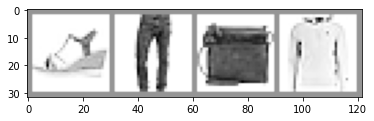

In [15]:
# show images
matplotlib_imshow(img_grid, one_channel=True)

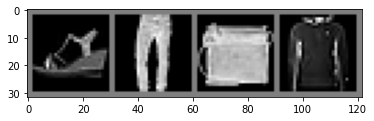

In [16]:
matplotlib_imshow(img_grid, one_channel=False)

图片在image窗口可视化

In [17]:
# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)#写入图片，第一个参数是名称，第二个是对象

之后用tensorboard --logdir=runs就可以启用服务器，在给出的网址看图了

还可以进行模型可视化，在graph窗口。

双击可以展开内容

In [18]:
writer.add_graph(net, images)#给一个输入参数有助于可视化和计算模型的输入输出维度
writer.close()

还可以添加数据降维映射，会出现在projection项目内 

In [19]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)#随机选取一部分数据来进行可视化

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,#特征信息
                    metadata=class_labels,#标签
                    label_img=images.unsqueeze(1))#原图
writer.close()

先弄两个辅助函数，处理数据和画图用

In [20]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    # 从图片到预测信息
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [21]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times
    # 只跑一轮
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),#这个函数添加的不是图形而是plt对象
                            global_step=epoch * len(trainloader) + i)#这里设置一下步数
            running_loss = 0.0
print('Finished Training')

Finished Training


这里计算一下PR曲线，tensorboard支持添加PR曲线对象

In [22]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

In [30]:
data[0].device#这个是没开cuda的数据，不过由于是一轮示例所以也没有太大问题

device(type='cpu')